In [1]:
import muon as mu
import pertpy as pt
import scanpy as sc
from anndata import AnnData
import numpy as np
import jax.numpy as jnp
import scanpy as sc
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


/home/tintra/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-12-16 09:20:55.924294: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-16 09:20:55.931445: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734340855.939914   16352 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734340855.942376   16352 cuda_blas.cc:1418] Unable to 

Link dataset [Single cell RNA sequencing of oropharyngeal squamous cell carcinoma](https://datasets.cellxgene.cziscience.com/915069db-1df2-49a1-9a9c-2fbd0aa13c81.h5ad)

In [2]:
adata = sc.read_h5ad("82k.h5ad")
adata

AnnData object with n_obs × n_vars = 82844 × 36397
    obs: 'nCount_RNA', 'nFeature_RNA', 'BarcodeID', 'sample_id', 'hpv_stat', 'source', 'digest', 'hpv_stat2', 'pct.mito', 'nCount_SCT', 'nFeature_SCT', 'scrun', 'Sample.type', 'Labels_broad', 'donor_id', 'protocol_url', 'institute', 'sample_collection_site', 'sample_collection_relative_time_point', 'library_id', 'library_id_repository', 'author_batch_notes', 'organism_ontology_term_id', 'manner_of_death', 'sample_source', 'sex_ontology_term_id', 'sample_collection_method', 'tissue_type', 'sampled_site_condition', 'tissue_ontology_term_id', 'tissue_free_text', 'sample_preservation_method', 'suspension_type', 'cell_enrichment', 'cell_viability_percentage', 'cell_number_loaded', 'sample_collection_year', 'assay_ontology_term_id', 'library_preparation_batch', 'library_sequencing_run', 'sequenced_fragment', 'sequencing_platform', 'is_primary_data', 'reference_genome', 'gene_annotation_version', 'alignment_software', 'intron_inclusion', 'dis

In [3]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, subset=True)
adata = adata[:, adata.var.highly_variable]

In [4]:
adata.obs['cell_type'].value_counts()

cell_type
epithelial cell                         21297
B cell                                  14675
CD4-positive, alpha-beta T cell         10364
CD8-positive, alpha-beta T cell          8701
plasma cell                              6929
myeloid cell                             6901
regulatory T cell                        4067
fibroblast                               3438
endothelial cell                         1810
mural cell                               1793
natural killer cell                      1398
mast cell                                 517
plasmacytoid dendritic cell               447
mature alpha-beta T cell                  302
endothelial cell of lymphatic vessel      205
Name: count, dtype: int64

In [5]:
from sklearn.covariance import empirical_covariance, ledoit_wolf, shrunk_covariance
from numbers import Real
import numpy as np
from scipy import linalg
from sklearn.preprocessing import StandardScaler
from time import time
from scipy.linalg import eig
from numpy import ndarray
import math


def power_method(A, num_iter=1000, tol=1e-6):
    """
    Finds the largest eigenvalue and corresponding eigenvector using the Power Method.
    """
    n = A.shape[0]
    b_k = np.random.rand(n)

    for _ in range(num_iter):
        # Multiply by the matrix
        b_k1 = np.dot(A, b_k)

        # Normalize the vector
        b_k1_norm = np.linalg.norm(b_k1)
        b_k1 = b_k1 / b_k1_norm

        # Check convergence
        if np.linalg.norm(b_k1 - b_k) < tol:
            break

        b_k = b_k1

    # Compute the Rayleigh quotient for the eigenvalue
    eigenvalue = np.dot(b_k.T, np.dot(A, b_k))

    return eigenvalue, b_k

def deflation(A, eigenvalue, eigenvector):
    """
    Performs deflation to remove the influence of a given eigenvalue and eigenvector.
    """
    return A - eigenvalue * np.outer(eigenvector, eigenvector)

def find_k_largest_eigenvalues(A, k, num_iter=1000, tol=1e-6):
    """
    Finds the k largest eigenvalues and their corresponding eigenvectors using the
    Power Method with Deflation.
    """
    n = A.shape[0]
    assert k <= n, "k cannot be larger than the size of the matrix"

    eigenvalues = []
    eigenvectors = []

    A_copy = A.copy()

    for _ in range(k):
        # Find the largest eigenvalue and eigenvector
        eigenvalue, eigenvector = power_method(A_copy, num_iter, tol)

        # Store the results
        eigenvalues.append(eigenvalue)
        eigenvectors.append(eigenvector)

        # Deflate the matrix
        A_copy = deflation(A_copy, eigenvalue, eigenvector)

    return np.array(eigenvalues), np.array(eigenvectors).T

def size(x):
    return math.prod(x.shape)

def compute_scatter_matrices(X, y):
    """
    Compute Within-Class Scatter (S_W) and Between-Class Scatter (S_B).
    
    Parameters:
    X : ndarray
        Feature matrix (n_samples, n_features).
    y : ndarray
        Class labels (n_samples,).
        
    Returns:
    S_W : ndarray
        Within-class scatter matrix (n_features, n_features).
    S_B : ndarray
        Between-class scatter matrix (n_features, n_features).
    """
    # Step 1: Compute overall mean
    overall_mean = np.mean(X, axis=0)
    
    # Step 2: Initialize scatter matrices
    n_features = X.shape[1]
    S_W = np.zeros((n_features, n_features))
    S_B = np.zeros((n_features, n_features))
    
    # Step 3: Compute scatter matrices
    classes = np.unique(y)
    for _class in classes:
        # Extract samples of the current class
        X_class = X[y == _class]
        
        # Compute mean vector for the current class
        class_mean = np.mean(X_class, axis=0)
        
        # Compute within-class scatter (S_W)
        n_class_samples = X_class.shape[0]
        X_class_centered = X_class - class_mean  # Center the data
        S_W += X_class_centered.T @ X_class_centered
        
        # Compute between-class scatter (S_B)
        mean_diff = (class_mean - overall_mean).reshape(-1, 1)
        S_B += n_class_samples * (mean_diff @ mean_diff.T)
    
    return S_W, S_B


class LDA:

    def __init__(
        self,

        shrinkage=None,
        priors=None,
        n_components=None,
        store_covariance=False,
        tol=1e-4,
        covariance_estimator=None,
    ):
        self.solver = 'eigen'
        self.shrinkage = shrinkage
        self.priors = priors
        self.n_components = n_components
        self.store_covariance = store_covariance  # used only in svd solver
        self.tol = tol  # used only in svd solver
        self.covariance_estimator = covariance_estimator

    def fit(self, X, y):
        self.classes_ = np.unique(y)
        n_samples, _ = X.shape
        n_classes = self.classes_.shape[0]

        if n_samples == n_classes:
            raise ValueError(
                "The number of samples must be more than the number of classes."
            )

        if self.priors is None:  # estimate priors from sample
            _, cnts = np.unique(y, return_counts=True)  # non-negative ints
            self.priors_ = (cnts / float(y.shape[0])).astype(X.dtype)
        else:
            self.priors_ = np.asarray(self.priors, dtype=X.dtype)

        if np.any(self.priors_ < 0):
            raise ValueError("priors must be non-negative")

        if np.abs(np.sum(self.priors_) - 1.0) > 1e-5:
            self.priors_ = self.priors_ / self.priors_.sum()

        # Maximum number of components no matter what n_components is
        # specified:
        max_components = min(n_classes - 1, X.shape[1])

        if self.n_components is None:
            self._max_components = max_components
        else:
            if self.n_components > max_components:
                raise ValueError(
                    "n_components cannot be larger than min(n_features, n_classes - 1)."
                )
            self._max_components = self.n_components

        self._solve_eigen(
            X,
            y,
            shrinkage=self.shrinkage,
            covariance_estimator=self.covariance_estimator,
        )

        self._n_features_out = self._max_components
        return self

    def _solve_eigen(self, X, y, shrinkage=None, covariance_estimator=None):
        start = time()
        # self.means_ = _class_means(X, y)
        # if isinstance(X, ndarray):
        #     self.covariance_ = _class_cov(
        #         X, y, self.priors_, shrinkage, covariance_estimator
        #     )
        #     Sw = self.covariance_  # within scatter
        #     St = _cov(X, shrinkage, covariance_estimator)  # total scatter
        # else:
        #     self.covariance_ = _class_cov(
        #         X.toarray(), y, self.priors_, shrinkage, covariance_estimator
        #     )
        #     Sw = self.covariance_  # within scatter
        #     St = _cov(X.toarray(), shrinkage, covariance_estimator)  # total scatter
        # Sb = St - Sw  # between scatter
        Sw, Sb = compute_scatter_matrices(X, y)
        end = time()
        
        print(f"Compute between and within class cost {end-start}")
        start = time()
        evals, evecs = find_k_largest_eigenvalues(np.linalg.inv(Sw).dot(Sb), self._max_components)
        end = time()
        print(f"Compute eigen cost {end-start}")
        
        self.explained_variance_ratio_ = np.sort(evals / np.sum(evals))[::-1][
            : self._max_components
        ]
        evecs = evecs[:, np.argsort(evals)[::-1]]  # sort eigenvectors

        self.scalings_ = evecs

    def transform(self, X):

        if self.solver == "svd":
            X_new = (X - self.xbar_) @ self.scalings_
        elif self.solver == "eigen":
            X_new = X @ self.scalings_[:, : self._max_components]
        return X_new

In [6]:
import psutil
process = psutil.Process()

Compute between and within class cost 4.809956073760986
Compute eigen cost 3.1118414402008057


/tmp/ipykernel_16352/2750635322.py:10: ImplicitModificationWarning: Setting element `.obsm['X_lda']` of view, initializing view as actual.
  adata.obsm['X_lda'] = X_new


Memory usage increased by: 286.71 MiB


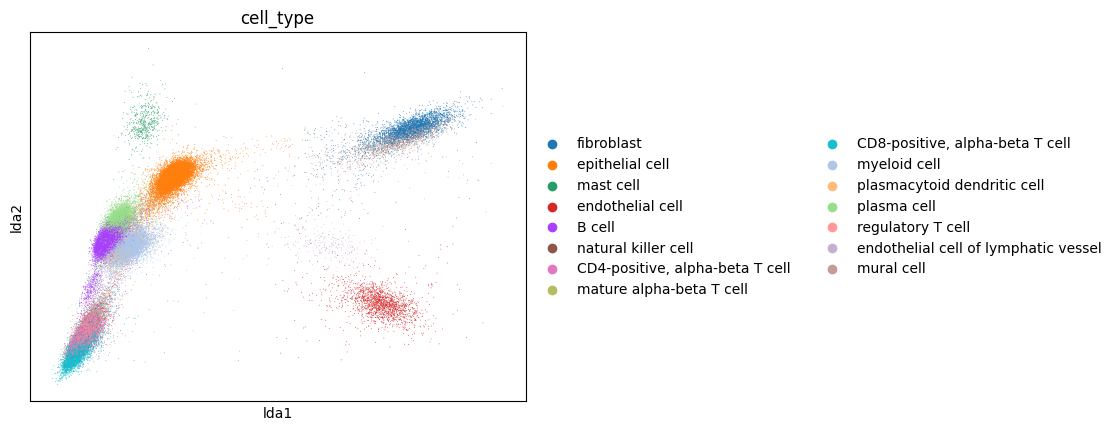

My LDA on (82844, 3205) took 8.62 seconds


In [7]:

def lda(adata):
    """
    Sklearn LDA fit and transform with timing and memory profiling.
    """
    # Sklearn LDA fit and transform
    start_mem = process.memory_info().rss / (1024 * 1024)  # Convert to MiB
    lda = LDA(n_components=2)
    lda.fit(adata.X, adata.obs['cell_type'])
    X_new = lda.transform(adata.X)
    adata.obsm['X_lda'] = X_new
    end_mem = process.memory_info().rss / (1024 * 1024)  # Convert to MiB
    print(f"Memory usage increased by: {end_mem - start_mem:.2f} MiB")
    return X_new

start = time()
X_new = lda(adata=adata)
end = time()


sc.pl.embedding(adata=adata, basis="lda", color="cell_type")
print(f"My LDA on {adata.X.shape} took {end - start:.2f} seconds")

Memory usage increased by: 2338.77 MiB


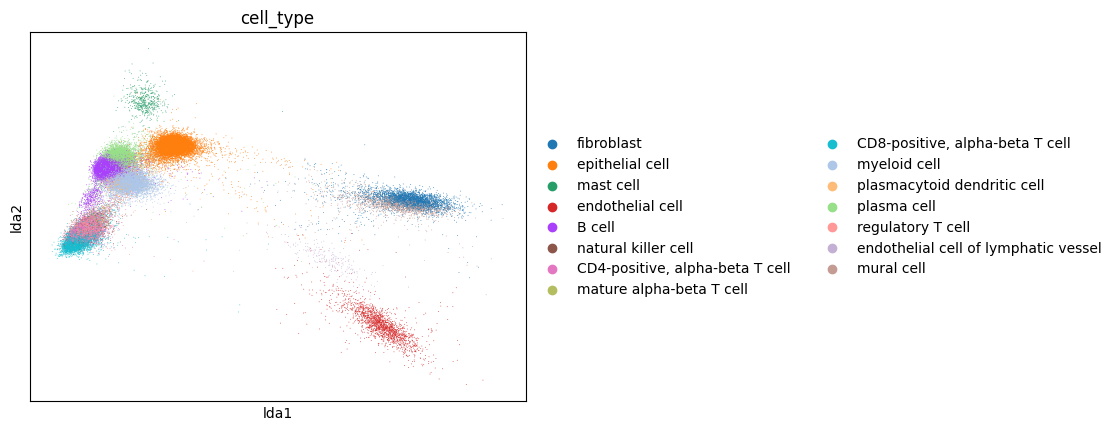

Sklearn LDA on (82844, 3205) took 39.63 seconds


In [8]:

def sklearn_lda(adata):
    """
    Sklearn LDA fit and transform with timing and memory profiling.
    """
    # Sklearn LDA fit and transform
    start_mem = process.memory_info().rss / (1024 * 1024)
    lda = LinearDiscriminantAnalysis(n_components=2, solver='eigen')
    lda.fit(adata.X.toarray(), adata.obs['cell_type'])
    X_new = lda.transform(adata.X.toarray())
    adata.obsm['X_lda'] = X_new
    end_mem = process.memory_info().rss / (1024 * 1024)
    print(f"Memory usage increased by: {end_mem - start_mem:.2f} MiB")
    return X_new

start = time()
X_new = sklearn_lda(adata=adata)
end = time()
sc.pl.embedding(adata=adata, basis="lda", color="cell_type")
print(f"Sklearn LDA on {adata.X.shape} took {end - start:.2f} seconds")